In [1]:
# Imports
from PIL import Image
from os import walk
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
def load_dataset(path):
    f = []
    
    # Find all images in folder
    for (dirpath, dirnames, filenames) in walk(path):
        f.extend(filenames)
        
        #print dirpath
        #print dirnames
        #print filenames
        
    images = []
    
    # For each image in folder
    for item in f:
        # Open and grayscale image
        image = Image.open(path+'/'+item).convert('L')

        # Get pixels from image (each pixel is into 0 to 255)
        pxl = np.array(list(image.getdata()))
        pxl = pxl.reshape(-1)
        
        images.append(pxl)
        
    images = np.array(images)
        
    return images, image.size, 

In [3]:
# Get all images and their hidth and height
data, (img_sizeW, img_sizeH) = load_dataset('input')

In [4]:
img_size_flat = img_sizeW * img_sizeH

In [5]:
def heaviside(x):
    # if -1: (-1+1)/2 = 0
    # if 0: (0+1)/2 = 0.5
    # if 1: (1+1)/2 = 1
    return 0.5 * (tf.sign(x) + 1) # 0.5 equal /2

In [6]:
H = [[ 
    [[ 0, 0, 0, 0, 0, 0, 0, 1]],
    [[ 1, 0, 0, 0, 0, 0, 0, 0]],
    [[ 0, 1, 0, 0, 0, 0, 0, 0]]
    ],
    [ 
    [[ 0, 0, 0, 0, 0, 0, 1, 0]],
    [[-1,-1,-1,-1,-1,-1,-1,-1]],
    [[ 0, 0, 1, 0, 0, 0, 0, 0]]
    ],
    [ 
    [[ 0, 0, 0, 0, 0, 1, 0, 0]],
    [[ 0, 0, 0, 0, 1, 0, 0, 0]],
    [[ 0, 0, 0, 1, 0, 0, 0, 0]]
]]
    
anchor_weights = tf.cast(H, tf.float32)

In [7]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat])

In [8]:
x_image = tf.reshape(x, [-1, img_sizeW, img_sizeH, 1])

In [9]:
bit_maps = tf.nn.conv2d(input=x_image,
                        filter=anchor_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

In [10]:
# Apply heaviside activation 
bit_maps = heaviside(bit_maps)

In [11]:
v = [2**7,2**6,2**5,2**4,2**3,2**2,2**1,2**0]

In [12]:
# TensorFlow session
session = tf.Session()

In [13]:
# Initializing variables
session.run(tf.global_variables_initializer())

In [14]:
# Get convoluted images with heaviside activation applied
out = session.run([bit_maps], feed_dict={x:data})[0]

In [15]:
anses = []

# For each image (we have 8 bit maps per image now)
for i in range(out.shape[0]):
    # Get array for one image (8 bit maps)
    tmp = out[i]
    tmp = np.transpose(tmp,(2, 0, 1))
    
    for j in range(8):
        tmp[j] *= v[j]
        
    tmp = tmp.reshape(8, -1)
    
    # Get weighted sum
    ans = np.sum(tmp, axis=0)
    ans = ans.reshape(img_sizeH, img_sizeW)
    anses.append(ans)

In [16]:
anses = np.array(anses)

In [17]:
output_path = 'output/'

In [18]:
for i in range(len(anses)):
    # For each pixel it into (0 - 255) now
    arr = anses[i].astype('uint8') 
    
    # Get image from that array
    image = Image.fromarray(arr)
    
    # Save as .jpg
    image.save(output_path+str(i)+'.png')

In [19]:
# Helper-function for plotting an image
def plot_image(image):
    plt.imshow(image.reshape(200, 200),
               interpolation='nearest',
               cmap='gray')

    plt.show()

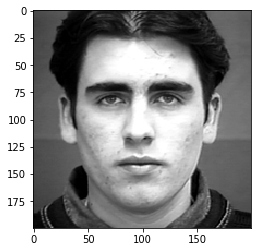

In [20]:
image = data[0] # Change 0 to see other images

plot_image(image)

In [21]:
# Helper-function for plotting convolutional weights
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2
    
    # Retrieve the values of the weight-variables from TensorFlow
    # A feed-dict is not necessary because nothing is calculated
    w = session.run(weights)

    # Get the lowest and highest values for the weights
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer
    num_filters = w.shape[3]

    # Create figure with a grid of sub-plots
    fig, axes = plt.subplots(4, 2)

    # Plot all the filter-weights
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights
        if i < num_filters:
            # Get the weights for the i'th filter of the input channel
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor
            image = w[:, :, input_channel, i]

            # Plot image
            ax.imshow(image, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

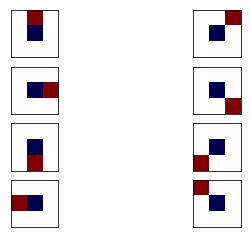

In [22]:
# Plot weights
plot_conv_weights(weights=anchor_weights)

In [23]:
def plot_conv_feature_maps(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2

    # Create a feed-dict containing just one image
    # Note that we don't need to feed y_true because it is
    # not used in this calculation
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer
    num_filters = values.shape[3]

    # Create figure with a grid of sub-plots
    fig, axes = plt.subplots(4, 2)

    # Plot the output images of all the filters
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters
        if i<num_filters:
            # Get the output image of using the i'th filter
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor
            image = values[0, :, :, i]

            # Plot image.
            ax.imshow(image, interpolation='nearest', cmap='gray')
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

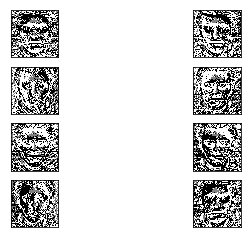

In [24]:
# Plot Feature Maps
plot_conv_feature_maps(layer=bit_maps, image=image)

In [25]:
# Close session
session.close()